In [1]:
# Remove input cells at runtime (nbsphinx)
import IPython.core.display as d
d.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# Instrument Response Functions (IRFs) and sensitivity

**Author(s):**
    
- Dr. Michele Peresano (CEA-Saclay/IRFU/DAp/LEPCHE), 2020
- Alice Donini (INFN Sezione di Trieste and Universita degli Studi di Udine), 2020
- Gaia Verna (Aix Marseille Univ, CNRS/IN2P3, CPPM, Marseille, France), 2020

based on [pyirf](https://github.com/cta-observatory/pyirf/blob/master/docs/notebooks/) .

**Description:**

This notebook contains DL3 and benchmarks for the _protopipe_ pipeline. 

Note that:
    - a more general set of benchmarks is being defined in cta-benchmarks/ctaplot,
    - follow [this](https://www.overleaf.com/16933164ghbhvjtchknf) document by adding new benchmarks or proposing new ones.

**Requirements:**

To run this notebook you will need a set of DL2 files produced on the grid with a performance script such as ``make_performance_EventDisplay.py`` .

The MC production to be used and the appropriate set of files to use for this notebook can be found [here](https://forge.in2p3.fr/projects/step-by-step-reference-mars-analysis/wiki#The-MC-sample ).

The DL2 data format required to run the notebook is the current one used by _protopipe_ , but it will converge to the one from _ctapipe_.

**Development and testing:**  

As with any other part of _protopipe_ and being part of the official repository, this notebook can be further developed by any interested contributor.  
The execution of this notebook is not currently automatic, it must be done locally by the user - preferably _before_ pushing a pull-request.  
**IMPORTANT:** Please, if you wish to contribute to this notebook, before pushing anything to your branch (better even before opening the PR) clear all the output and remove any local directory paths that you used for testing (leave empty strings).

**TODO:**  
- ...

## Table of contents

* [Optimized cuts](#Optimized-cuts)
    - [Direction cut](#Direction-cut)
    - [Gamma/Hadron separation](#Gamma/Hadron-separation)
* [Differential sensitivity from cuts optimization](#Differential-sensitivity-from-cuts-optimization)
* [Sensitivity against requirements](#Sensitivity-against-requirements)
* [Sensitivity comparison between pipelines](#Sensitivity-comparison-between-pipelines)
* [IRFs](#IRFs)
    - [Effective area](#Effective-area)
    - [Point Spread Function](#Point-Spread-Function)
        + [Angular resolution](#Angular-resolution)
    - [Energy dispersion](#Energy-dispersion)
        + [Energy resolution](#Energy-resolution)
    - [Background rate](#Background-rate)

## Imports
[back to top](#Table-of-contents)

In [2]:
# From the standard library
import os
from pathlib import Path

# From pyirf
import pyirf
from pyirf.binning import bin_center
from pyirf.utils import cone_solid_angle

# From other 3rd-party libraries
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.table import QTable, Table, Column
import uproot

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

## Input data
[back to top](#Table-of-contents)

In [3]:
production = "Prod3b_CTANorth_full_baseline_array_Zd20deg_Az180deg_50h"

In [4]:
# First we check if a _plots_ folder exists already.  
# If not, we create it.
Path("./plots").mkdir(parents=True, exist_ok=True)

### Protopipe
[back to top](#Table-of-contents)

In [5]:
#Path to the performance folder
parent_dir = "/Users/michele/Applications/ctasoft/dirac/shared_folder/analyses"
analysisName = "v0.4.0_dev0"
infile = "performance_protopipe_CTANorth_full_array_Zd20deg_180deg_Time50.00h_eres2.fits.gz"
protopipe_file = Path(parent_dir, analysisName, "data/DL3", infile)

### ASWG performance
[back to top](#Table-of-contents)

In [6]:
parent_dir_aswg = "/Volumes/DataCEA_PERESANO/Data/CTA/ASWG"

In [7]:
# MARS performance (available here: https://forge.in2p3.fr/projects/step-by-step-reference-mars-analysis/wiki)
indir_CTAMARS = "Prod3b/CTAMARS_reference_data/DL3/point-like/LaPalma_20_South"
infile_CTAMARS = "SubarrayLaPalma_4L15M_south_IFAE_50hours_20190630.root"
MARS_performance = uproot.open(Path(parent_dir_aswg, indir_CTAMARS, infile_CTAMARS))

MARS_label = "CTAMARS (2019)"

In [8]:
# ED performance (available here: https://forge.in2p3.fr/projects/cta_analysis-and-simulations/wiki/Prod3b_based_instrument_response_functions)
indir_ED = "Prod3b/Release_2018-12-03/ROOT/North/CTA-Performance-North-20deg_20181203"
infile_ED = "CTA-Performance-North-20deg-S-50h_20181203.root"
ED_performance = uproot.open(Path(parent_dir_aswg, indir_ED, infile_ED))

ED_label = "EventDisplay (2018)"

### Requirements
[back to top](#Table-of-contents)

In [9]:
indir = './requirements'

site = 'North'
obs_time = '50h'

# Full array
infiles = dict(sens=f'/{site}-{obs_time}.dat') # 30 min
requirements = dict()
for key in infiles.keys():
    requirements[key] = Table.read(indir + infiles[key], format='ascii')
requirements['sens'].add_column(Column(data=(10**requirements['sens']['col1']), name='ENERGY'))
requirements['sens'].add_column(Column(data=requirements['sens']['col2'], name='SENSITIVITY'))

## Optimized cuts
[back to top](#Table-of-contents)

### Direction
[back to top](#Table-of-contents)

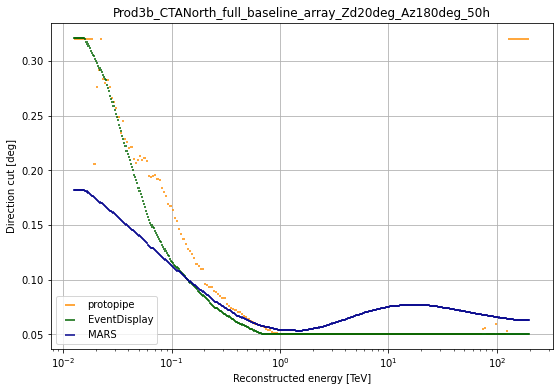

In [10]:
# protopipe
rad_max = QTable.read(protopipe_file, hdu='RAD_MAX')[0]
plt.errorbar(
    0.5 * (rad_max['ENERG_LO'] + rad_max['ENERG_HI'])[1:-1].to_value(u.TeV),
    rad_max['RAD_MAX'].T[1:-1, 0].to_value(u.deg),
    xerr=0.5 * (rad_max['ENERG_HI'] - rad_max['ENERG_LO'])[1:-1].to_value(u.TeV),
    ls='',
    label='protopipe',
    color='DarkOrange'
)

# ED
theta_cut_ed, edges = ED_performance['ThetaCut;1'].to_numpy()
plt.errorbar(
    bin_center(10**edges),
    theta_cut_ed,
    xerr=np.diff(10**edges),
    ls='',
    label='EventDisplay',
    color='DarkGreen'
)

# MARS
theta_cut_ed = np.sqrt(MARS_performance['Theta2Cut;1'].to_numpy()[0])
edges = MARS_performance['Theta2Cut;1'].to_numpy()[1]
plt.errorbar(
    bin_center(10**edges),
    theta_cut_ed,
    xerr=np.diff(10**edges),
    ls='',
    label='MARS',
    color='DarkBlue'
)

plt.legend()
plt.ylabel('Direction cut [deg]')
plt.xlabel('Reconstructed energy [TeV]')
plt.xscale('log')
plt.title(production)
plt.grid()

None # to remove clutter by mpl objects

### Gamma/Hadron separation
[back to top](#Table-of-contents)

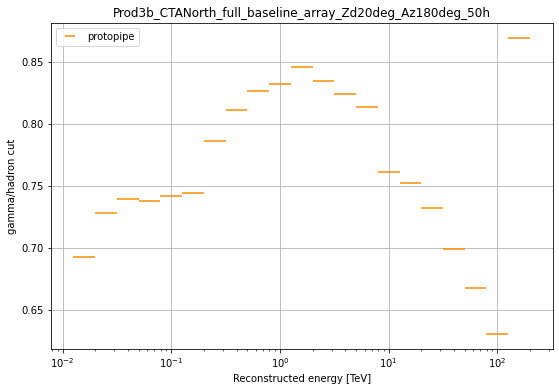

In [11]:
# protopipe
gh_cut = QTable.read(protopipe_file, hdu='GH_CUTS')[1:-1]
plt.errorbar(
    0.5 * (gh_cut['low'] + gh_cut['high']).to_value(u.TeV),
    gh_cut['cut'],
    xerr=0.5 * (gh_cut['high'] - gh_cut['low']).to_value(u.TeV),
    ls='',
    label='protopipe',
    color='DarkOrange'
)

plt.legend()
plt.ylabel('gamma/hadron cut')
plt.xlabel('Reconstructed energy [TeV]')
plt.xscale('log')
plt.title(production)
plt.grid()

None # to remove clutter by mpl objects

## Differential sensitivity from cuts optimization
[back to top](#Table-of-contents)

In [12]:
# [1:-1] removes under/overflow bins
sensitivity_protopipe = QTable.read(protopipe_file, hdu='SENSITIVITY')[1:-1]

# make it print nice
sensitivity_protopipe['reco_energy_low'].info.format = '.3g'
sensitivity_protopipe['reco_energy_high'].info.format = '.3g'
sensitivity_protopipe['reco_energy_center'].info.format = '.3g'
sensitivity_protopipe['relative_sensitivity'].info.format = '.2g'
sensitivity_protopipe['flux_sensitivity'].info.format = '.3g'

for k in filter(lambda k: k.startswith('n_'), sensitivity_protopipe.colnames):
    sensitivity_protopipe[k].info.format = '.1f'

sensitivity_protopipe

reco_energy_low,reco_energy_high,reco_energy_center,n_signal,n_signal_weighted,n_background,n_background_weighted,significance,relative_sensitivity,flux_sensitivity
TeV,TeV,TeV,,,,,,,1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0126,0.02,0.0163,6.5,10.0,0.0,0.0,5.986250026900072,0.59,8.1e-07
0.02,0.0316,0.0258,731.9,974.4,121.8,97440.6,6.31113400697068,0.075,3.09e-08
0.0316,0.0501,0.0409,595.7,669.5,88.3,66952.4,5.23143133904108,0.046,5.7e-09
0.0501,0.0794,0.0648,733.8,595.1,120.4,57876.2,4.999999999999727,0.027,9.98e-10
0.0794,0.126,0.103,1060.5,611.9,217.3,61194.5,5.001425211104175,0.013,1.41e-10
0.126,0.2,0.163,1177.5,512.8,243.4,42841.5,5.000000000001148,0.0067,2.22e-11
0.2,0.316,0.258,647.4,206.9,90.8,6736.5,5.000000000000677,0.0051,5.02e-12
0.316,0.501,0.409,428.9,101.9,43.8,1540.5,5.000000000021183,0.0043,1.28e-12


## Sensitivity against requirements
[back to top](#Table-of-contents)

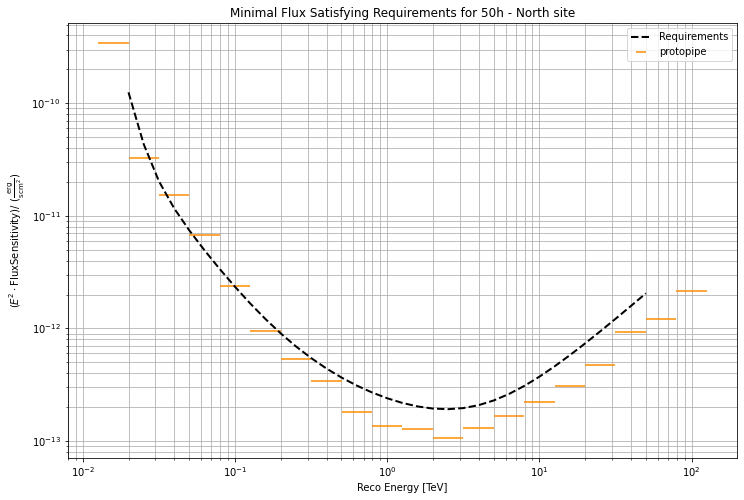

In [13]:
plt.figure(figsize=(12,8))

unit = u.Unit('erg cm-2 s-1')

# protopipe
e = sensitivity_protopipe['reco_energy_center']
w = (sensitivity_protopipe['reco_energy_high'] - sensitivity_protopipe['reco_energy_low'])
s = (e**2 * sensitivity_protopipe['flux_sensitivity'])

plt.errorbar(
    e.to_value(u.TeV),
    s.to_value(unit),
    xerr=w.to_value(u.TeV) / 2,
    ls='',
    label='protopipe',
    color='DarkOrange'
)

# Add requirements
plt.plot(requirements['sens']['ENERGY'], 
         requirements['sens']['SENSITIVITY'], 
         color='black', 
         ls='--', 
         lw=2, 
         label='Requirements'
)

# Style settings
plt.title(f'Minimal Flux Satisfying Requirements for {obs_time} - {site} site')
plt.xscale("log")
plt.yscale("log")
plt.ylabel(rf"$(E^2 \cdot \mathrm{{Flux Sensitivity}}) /$ ({unit.to_string('latex')})")
plt.xlabel("Reco Energy [TeV]")

plt.grid(which="both")
plt.legend()


None # to remove clutter by mpl objects


## Sensitivity comparison between pipelines
[back to top](#Table-of-contents)

<Figure size 864x576 with 0 Axes>

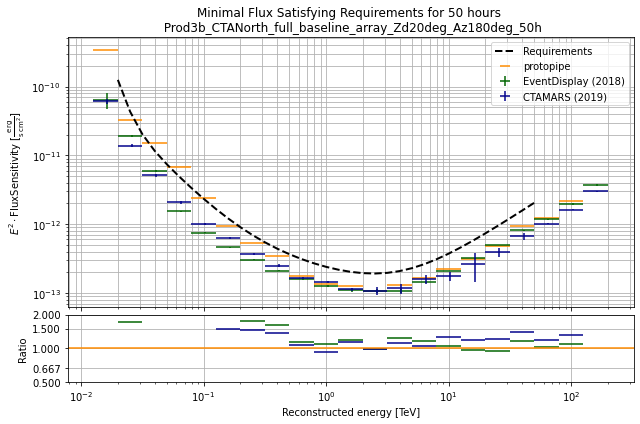

In [14]:
plt.figure(figsize=(12,8))
fig, (ax_sens, ax_ratio) = plt.subplots(
    2, 1,
    gridspec_kw={'height_ratios': [4, 1]},
    sharex=True,
)
unit = u.Unit('erg cm-2 s-1')

# Add requirements
ax_sens.plot(requirements['sens']['ENERGY'], 
         requirements['sens']['SENSITIVITY'], 
         color='black', 
         ls='--', 
         lw=2, 
         label='Requirements'
)

# protopipe
e = sensitivity_protopipe['reco_energy_center']
w = (sensitivity_protopipe['reco_energy_high'] - sensitivity_protopipe['reco_energy_low'])
s_p = (e**2 * sensitivity_protopipe['flux_sensitivity'])
ax_sens.errorbar(
    e.to_value(u.TeV),
    s_p.to_value(unit),
    xerr=w.to_value(u.TeV) / 2,
    ls='',
    label='protopipe',
    color='DarkOrange'
)

# ED
s_ED, edges = ED_performance["DiffSens"].to_numpy()
yerr = ED_performance["DiffSens"].errors()
bins = 10**edges
x = bin_center(bins)
width = np.diff(bins)
ax_sens.errorbar(
    x,
    s_ED, 
    xerr=width/2,
    yerr=yerr,
    label=ED_label,
    ls='',
    color='DarkGreen'
)

# MARS
s_MARS, edges = MARS_performance["DiffSens"].to_numpy()
yerr = MARS_performance["DiffSens"].errors()
bins = 10**edges
x = bin_center(bins)
width = np.diff(bins)
ax_sens.errorbar(
    x,
    s_MARS, 
    xerr=width/2,
    yerr=yerr,
    label=MARS_label,
    ls='',
    color='DarkBlue'
)

ax_ratio.errorbar(
    e.to_value(u.TeV), 
    s_p.to_value(unit) / s_ED,
    xerr=w.to_value(u.TeV)/2,
    ls='',
    label = "",
    color='DarkGreen'
)
ax_ratio.errorbar(
    e.to_value(u.TeV), 
    s_p.to_value(unit) / s_MARS,
    xerr=w.to_value(u.TeV)/2,
    ls='',
    label = "",
    color='DarkBlue'
)
ax_ratio.axhline(1, color = 'DarkOrange')

ax_ratio.set_yscale('log')
ax_ratio.set_xlabel("Reconstructed energy [TeV]")
ax_ratio.set_ylabel('Ratio')
ax_ratio.grid()
ax_ratio.yaxis.set_major_formatter(ScalarFormatter())

ax_ratio.set_ylim(0.5, 2.0)
ax_ratio.set_yticks([0.5, 2/3, 1, 3/2, 2])
ax_ratio.set_yticks([], minor=True)

# Style settings
ax_sens.set_title(f'Minimal Flux Satisfying Requirements for 50 hours \n {production}')
ax_sens.set_xscale("log")
ax_sens.set_yscale("log")
ax_sens.set_ylabel(rf"$E^2 \cdot \mathrm{{Flux Sensitivity}} $ [{unit.to_string('latex')}]")

ax_sens.grid(which="both")
ax_sens.legend()
fig.tight_layout(h_pad=0)


None # to remove clutter by mpl objects

## IRFs
[back to top](#Table-of-contents)

### Effective area
[back to top](#Table-of-contents)

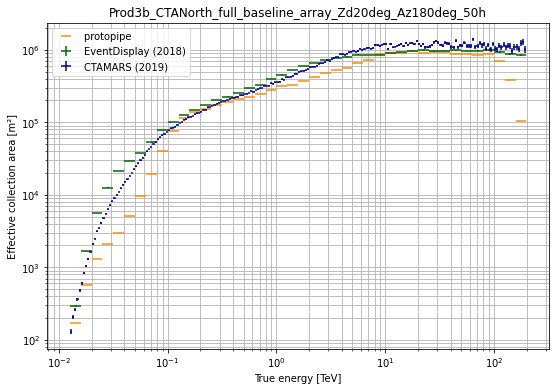

In [15]:
# protopipe
# uncomment the other strings to see effective areas
# for the different cut levels. Left out here for better
# visibility of the final effective areas.
suffix =''
#'_NO_CUTS'
#'_ONLY_GH'
#'_ONLY_THETA'

area = QTable.read(protopipe_file, hdu='EFFECTIVE_AREA' + suffix)[0]
plt.errorbar(
    0.5 * (area['ENERG_LO'] + area['ENERG_HI']).to_value(u.TeV)[1:-1],
    area['EFFAREA'].to_value(u.m**2).T[1:-1, 0],
    xerr=0.5 * (area['ENERG_LO'] - area['ENERG_HI']).to_value(u.TeV)[1:-1],
    ls='',
    label='protopipe ' + suffix,
    color='DarkOrange'
)
    
# ED
y, edges = ED_performance["EffectiveAreaEtrue"].to_numpy()
yerr = ED_performance["EffectiveAreaEtrue"].errors()
x = bin_center(10**edges)
xerr = 0.5 * np.diff(10**edges)
plt.errorbar(x, 
             y, 
             xerr=xerr, 
             yerr=yerr, 
             ls='', 
             label=ED_label,
             color='DarkGreen'
            )

# MARS
y, edges = MARS_performance["EffectiveAreaEtrue"].to_numpy()
yerr = MARS_performance["EffectiveAreaEtrue"].errors()
x = bin_center(10**edges)
xerr = 0.5 * np.diff(10**edges)
plt.errorbar(x, 
             y, 
             xerr=xerr, 
             yerr=yerr, 
             ls='', 
             label=MARS_label,
             color='DarkBlue'
            )

# Style settings
plt.xscale("log")
plt.yscale("log")
plt.xlabel("True energy [TeV]")
plt.ylabel("Effective collection area [m²]")
plt.title(production)
plt.grid(which="both")
plt.legend()

None # to remove clutter by mpl objects

### Point Spread Function
[back to top](#Table-of-contents)

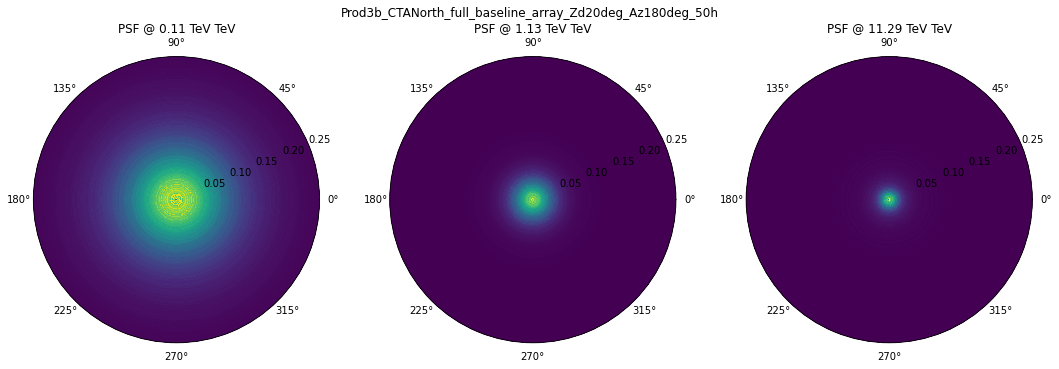

In [16]:
psf_table = QTable.read(protopipe_file, hdu='PSF')[0]
# select the only fov offset bin
psf = psf_table['RPSF'].T[:, 0, :].to_value(1 / u.sr)

offset_bins = np.append(psf_table['RAD_LO'], psf_table['RAD_HI'][-1])
phi_bins = np.linspace(0, 2 * np.pi, 100)



# Let's make a nice 2d representation of the radially symmetric PSF
r, phi = np.meshgrid(offset_bins.to_value(u.deg), phi_bins)

# look at a single energy bin
# repeat values for each phi bin
center = 0.5 * (psf_table['ENERG_LO'] + psf_table['ENERG_HI'])


fig = plt.figure(figsize=(15, 5))
plt.suptitle(production)
axs = [fig.add_subplot(1, 3, i, projection='polar') for i in range(1, 4)]


for bin_id, ax in zip([10, 20, 30], axs):
    image = np.tile(psf[bin_id], (len(phi_bins) - 1, 1))
    
    ax.set_title(f'PSF @ {center[bin_id]:.2f} TeV')
    ax.pcolormesh(phi, r, image)
    ax.set_ylim(0, 0.25)
    ax.set_aspect(1)
    
fig.tight_layout()

None # to remove clutter by mpl objects


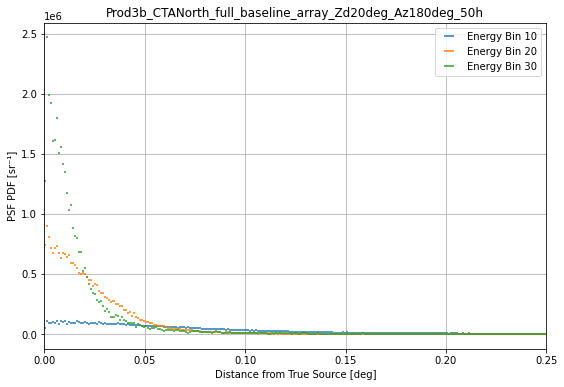

In [17]:
# Profile
center = 0.5 * (offset_bins[1:] + offset_bins[:-1])
xerr = 0.5 * (offset_bins[1:] - offset_bins[:-1])

for bin_id in [10, 20, 30]:
    plt.errorbar(
        center.to_value(u.deg),
        psf[bin_id],
        xerr=xerr.to_value(u.deg),
        ls='',
        label=f'Energy Bin {bin_id}'
    )
    
#plt.yscale('log')
plt.legend()
plt.xlim(0, 0.25)
plt.ylabel('PSF PDF [sr⁻¹]')
plt.xlabel('Distance from True Source [deg]')
plt.title(production)
plt.grid()

None # to remove clutter by mpl objects

#### Angular resolution
[back to top](#Table-of-contents)

NOTE: MARS and EventDisplay Angular Resolution are plotted as a function of Reco Energy, protopipe ones as a function of True Energy

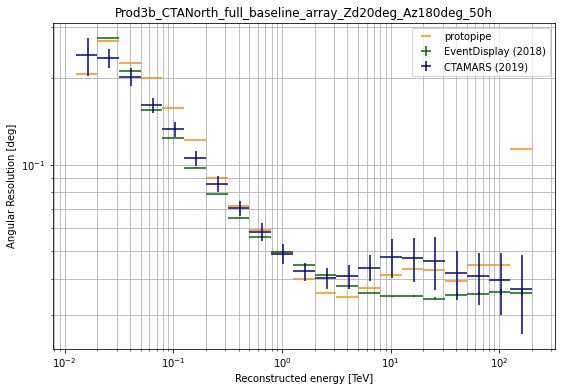

In [18]:
# protopipe
ang_res = QTable.read(protopipe_file, hdu='ANGULAR_RESOLUTION')[1:-1]

plt.errorbar(
    0.5 * (ang_res['reco_energy_low'] + ang_res['reco_energy_high']).to_value(u.TeV),
    ang_res['angular_resolution'].to_value(u.deg),
    xerr=0.5 * (ang_res['reco_energy_high'] - ang_res['reco_energy_low']).to_value(u.TeV),
    ls='',
    label='protopipe',
    color='DarkOrange'
)

# ED
y, edges = ED_performance["AngRes"].to_numpy()
yerr = ED_performance["AngRes"].errors()
x = bin_center(10**edges)
xerr = 0.5 * np.diff(10**edges)
plt.errorbar(x, 
             y, 
             xerr=xerr, 
             yerr=yerr, 
             ls='', 
             label=ED_label,
             color='DarkGreen')

# MARS
y, edges = MARS_performance["AngRes"].to_numpy()
yerr = MARS_performance["AngRes"].errors()
x = bin_center(10**edges)
xerr = 0.5 * np.diff(10**edges)
plt.errorbar(x, 
             y, 
             xerr=xerr, 
             yerr=yerr, 
             ls='', 
             label=MARS_label,
             color='DarkBlue')

# Style settings
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Reconstructed energy [TeV]")
plt.ylabel("Angular Resolution [deg]")
plt.title(production)
plt.grid(which="both")
plt.legend(loc="best")

None # to remove clutter by mpl objects

### Energy dispersion
[back to top](#Table-of-contents)

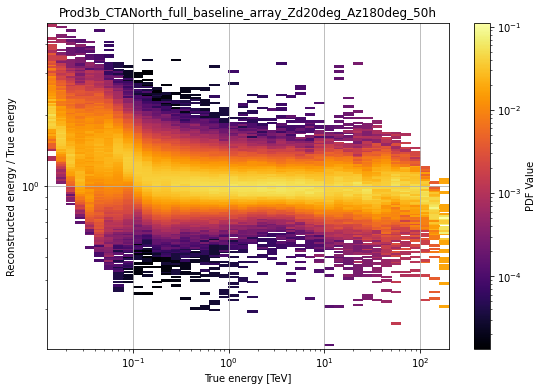

In [19]:
from matplotlib.colors import LogNorm

edisp = QTable.read(protopipe_file, hdu='ENERGY_DISPERSION')[0]

e_bins = edisp['ENERG_LO'][1:]
migra_bins = edisp['MIGRA_LO'][1:]

plt.title(production)
plt.pcolormesh(e_bins.to_value(u.TeV), 
               migra_bins, 
               edisp['MATRIX'].T[1:-1, 1:-1, 0].T,
               cmap='inferno',
               norm=LogNorm())

plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.colorbar(label='PDF Value')

plt.xlabel("True energy [TeV]")
plt.ylabel("Reconstructed energy / True energy")

None # to remove clutter by mpl objects

#### Energy resolution
[back to top](#Table-of-contents)

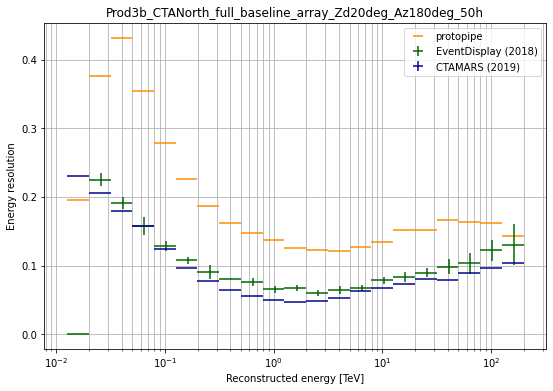

In [20]:
# protopipe
bias_resolution = QTable.read(protopipe_file, hdu='ENERGY_BIAS_RESOLUTION')[1:-1]
plt.errorbar(
    0.5 * (bias_resolution['reco_energy_low'] + bias_resolution['reco_energy_high']).to_value(u.TeV),
    bias_resolution['resolution'],
    xerr=0.5 * (bias_resolution['reco_energy_high'] - bias_resolution['reco_energy_low']).to_value(u.TeV),
    ls='',
    label='protopipe',
    color='DarkOrange'
)
plt.xscale('log')


# ED
y, edges = ED_performance["ERes"].to_numpy()
yerr = ED_performance["ERes"].errors()
x = bin_center(10**edges)
xerr = np.diff(10**edges) / 2
plt.errorbar(x, 
             y, 
             xerr=xerr, 
             yerr=yerr, 
             ls='', 
             label=ED_label,
             color='DarkGreen'
            )

# MARS
y, edges = MARS_performance["ERes"].to_numpy()
yerr = MARS_performance["ERes"].errors()
x = bin_center(10**edges)
xerr = np.diff(10**edges) / 2
plt.errorbar(x, 
             y, 
             xerr=xerr, 
             yerr=yerr, 
             ls='', 
             label=MARS_label,
             color='DarkBlue'
            )

# Style settings
plt.xlabel("Reconstructed energy [TeV]")
plt.ylabel("Energy resolution")
plt.grid(which="both")
plt.legend(loc="best")
plt.title(production)

None # to remove clutter by mpl objects

### Background rate
[back to top](#Table-of-contents)

/Users/michele/Applications/miniconda3/envs/protopipe/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


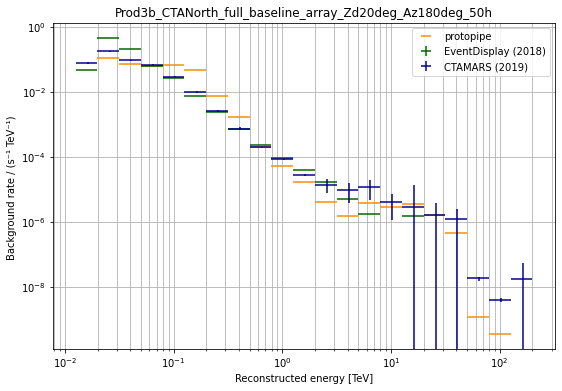

In [21]:
from pyirf.utils import cone_solid_angle

# protopipe
bg_rate = QTable.read(protopipe_file, hdu='BACKGROUND')[0]

reco_bins = np.append(bg_rate['ENERG_LO'], bg_rate['ENERG_HI'][-1])

# first fov bin, [0, 1] deg
fov_bin = 0
rate_bin = bg_rate['BKG'].T[:, fov_bin]

# interpolate theta cut for given e reco bin
e_center_bg = 0.5 * (bg_rate['ENERG_LO'] + bg_rate['ENERG_HI'])
e_center_theta = 0.5 * (rad_max['ENERG_LO'] + rad_max['ENERG_HI'])
theta_cut = np.interp(e_center_bg, e_center_theta, rad_max['RAD_MAX'].T[:, 0])

# undo normalization
rate_bin *= cone_solid_angle(theta_cut)
rate_bin *= np.diff(reco_bins)
plt.errorbar(
    0.5 * (bg_rate['ENERG_LO'] + bg_rate['ENERG_HI']).to_value(u.TeV)[1:-1],
    rate_bin.to_value(1 / u.s)[1:-1],
    xerr=np.diff(reco_bins).to_value(u.TeV)[1:-1] / 2,
    ls='',
    label='protopipe',
    color='DarkOrange'
)

# ED
y, edges = ED_performance["BGRate"].to_numpy()
yerr = ED_performance["BGRate"].errors()
x = bin_center(10**edges)
xerr = np.diff(10**edges) / 2
plt.errorbar(x, 
             y, 
             xerr=xerr, 
             yerr=yerr, 
             ls='', 
             label=ED_label,
             color="DarkGreen")


# MARS
y, edges = MARS_performance["BGRate"].to_numpy()
yerr = MARS_performance["BGRate"].errors()
x = bin_center(10**edges)
xerr = np.diff(10**edges) / 2
plt.errorbar(x, 
             y, 
             xerr=xerr, 
             yerr=yerr, 
             ls='', 
             label=MARS_label,
             color="DarkBlue")


# Style settings
plt.xscale("log")
plt.xlabel("Reconstructed energy [TeV]")
plt.ylabel("Background rate / (s⁻¹ TeV⁻¹) ")
plt.grid(which="both")
plt.legend(loc="best")
plt.title(production)
plt.yscale('log')

None # to remove clutter by mpl objects